In [1]:
import sys
print(sys.executable)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from time import time
import pandas as pd
from glob import glob
from KerasOCRTrainer2 import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import cv2
from PIL import Image
from random import shuffle

C:\Users\Hardie\Anaconda3\envs\tflow\python.exe
C:\Users\Hardie\Anaconda3\envs\tflow\python.exe


In [2]:
# tf.test.is_gpu_available()

# Create df to flow from

In [3]:
# ubuntu
file_list_2 = glob('../data/data2/*/*.png')
shuffle(file_list_2)
file_list_4 = glob('../data/data4/*/*.png')
# shuffle(file_list_4)
file_list_5 = glob('../data/data5/*/*.png')
# shuffle(file_list_5)
file_list_6 = glob('../data/data6/*/*.png')
# shuffle(file_list_6)
file_list_7 = glob('../data/data7/*/*.png')
# shuffle(file_list_7)
file_list_t = glob('../data/training_data/*/*.jpg')
shuffle(file_list_t)
print(f'this is a list{file_list_2}')

file_list = file_list_2+file_list_4+file_list_5+file_list_6+file_list_7
shuffle(file_list)

file_list = [s.replace('/','\\') for s in file_list]

print(f'this is a list{file_list}')

# mac
# file_list = glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/data2/*/*.png')
# file_list = file_list+glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/training_data/numbers_96/*/*.jpg')
df_lst = []
for file_path in file_list:
    label = file_path.split('\\')[-2]
#     print(label)
    alt_label = label
    while len(alt_label)<3:
        alt_label = ' '+alt_label
    if alt_label == 'nan':
        alt_label = '   '
#     print(alt_label)    
    l0,l1,l2 = alt_label
    
    df_lst.append({
        'file_path': file_path,
        'single_label':label,
        'multi_label':np.array([l0,l1,l2]),
        'l0':str(l0),
        'l1':str(l1),
        'l2':str(l2),
#         'splitable':f'{l0},{l1},{l2}'
    }
    )
df = pd.DataFrame(df_lst)
print(df.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(708004, 6)


In [109]:
labels = range(0, 20+1)
labels = [str(i) for i in labels]
df_trunc = df[df['single_label'].isin(labels)]
df = df_trunc

In [110]:
def one_hot(cat):
    categories = [' ','0','1','2','3','4','5','6','7','8','9']
    return (cat==np.array(categories) ).astype(int).tolist()

categories = [' ','0','1','2','3','4','5','6','7','8','9']
for col in ['l0','l1','l2']:
    df[col+'d'] = df[col].apply(one_hot)
df.head()

C:\Users\Hardie\Anaconda3\envs\tflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,file_path,single_label,multi_label,l0,l1,l2,l0d,l1d,l2d
0,..\data\data6\11\134_92_lQ8NQb_viSvjI.png,11,"[ , 1, 1]",,1,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
12,..\data\data2\15\164_115_GCMkFA_xCmCXm.png,15,"[ , 1, 5]",,1,5,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
18,..\data\data4\14\230_148_VAJvqs_zcwpMr.png,14,"[ , 1, 4]",,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
47,..\data\data4\14\221_155_pcMhYN_htbKWm.png,14,"[ , 1, 4]",,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
48,..\data\data6\10\158_93_4PAQje_xmbaMp.png,10,"[ , 1, 0]",,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


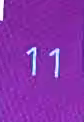

In [111]:
def random_perspective(img):
#     if np.random.randint(3)!=0:
#         pass
#     else:
#         img= np.rot90(img)
    
    
    # only apply to every n_th image
    if np.random.randint(3)!=0:
        return img
    MAX_CHANGE = 0.2
    a = np.random.rand(8).reshape(4,2)
    width, height = img.shape[:2]
    scale_factor = min(width,height)
    a = a*scale_factor*MAX_CHANGE
    pts1 = np.float32([
        [0,0],
        [width,0],
        [width,height],
        [0,height]
    ])
    pts2 = np.float32([
        [0+a[0,0],0+a[0,1]],
        [width-a[1,0],0+a[1,1]],
        [width-a[2,0],height-a[2,1]],
        [0+a[3,0],height-a[3,1]]
    ])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img, M, (height,width))
    
    return img

path = file_list[0]
img = cv2.imread(path)
img = random_perspective(img)

Image.fromarray(img)

## Option 2

In [112]:
im_size = 48
ks = 5

mini_df = df

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.1,
    preprocessing_function = random_perspective
)

y_col = ['l0d','l1d','l2d']
class_mode = 'multi_output'

dirt = 'C:\\Users\\Hardie\\Desktop\\Eduard Model\\data'

train_generator = train_datagen.flow_from_dataframe(
    mini_df, directory=dirt, x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="training", classes=categories,
    batch_size=1024, seed=42)

valid_generator = train_datagen.flow_from_dataframe(
    mini_df, directory=dirt, x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="validation", classes=categories,
    batch_size=1024, seed=42)

C:\Users\Hardie\Anaconda3\envs\tflow\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="multi_output"
  .format(self.class_mode))


Found 40275 validated image filenames.
Found 4474 validated image filenames.


### Define model

In [123]:
# Model built by Hardie
# Lets use a ResNet, state of the art and tends to train easier.

# Resnet code grabbed from:
# https://keras.io/examples/cifar10_resnet/

import tensorflow.keras as keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


# Build the network using this function
def resnet(input_shape, depth):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10) REMOVED

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    
    # On eduards request
    x = BatchNormalization()(inputs)    
    #x = resnet_layer(inputs=inputs)
    x = resnet_layer(x)
    
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    
    # Hardie: Hack to get the resnet to work with current workflow
    #dense1 = Dense(200,activation='relu')(x) # 
    num1 = Dense(11,activation='softmax',name='num1')(x)
    num2 = Dense(11,activation='softmax',name='num2')(x)
    num3 = Dense(11,activation='softmax',name='num3')(x)
    
#     outputs = Dense(num_classes,
#                     activation='softmax',
#                     kernel_initializer='he_normal')(y)

    # Instantiate model.
    # Old: model = Model(inputs=inputs, outputs=outputs)
    model = Model(inputs = inputs, outputs=[num1,num2,num3])
    return model

shape=(im_size, im_size, 3)
model = resnet(shape, 20)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_168 (BatchN (None, 48, 48, 3)    12          input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 48, 48, 16)   448         batch_normalization_168[0][0]    
__________________________________________________________________________________________________
batch_normalization_169 (BatchN (None, 48, 48, 16)   64          conv2d_186[0][0]                 
___________________________________________________________________________________________

In [124]:
if False:
    # kernale size
    ks = 5
    # number of filters
    nf = 32
    input_img = Input(shape=(im_size, im_size, 3))
    print(input_img)
    # gs_img = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input_img)
    conv1 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(input_img)
    drop1 = Dropout(0.05)(conv1)
    conv2 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(drop1)
    drop2 = Dropout(0.05)(conv2)
    conv3 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(drop2)
    flat1  = Flatten()(conv3)
    dense1 = Dense(256,activation='relu')(flat1)
    num1 = Dense(11,activation='softmax',name='num1')(dense1)
    num2 = Dense(11,activation='softmax',name='num2')(dense1)
    num3 = Dense(11,activation='softmax',name='num3')(dense1)

    # output = keras.layers.concatenate([num1,num2,num3])
    # output = [num1,num2,num3]?
    model = Model(inputs = input_img, outputs=[num1,num2,num3])
    model

In [125]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [126]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_168 (BatchN (None, 48, 48, 3)    12          input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 48, 48, 16)   448         batch_normalization_168[0][0]    
__________________________________________________________________________________________________
batch_normalization_169 (BatchN (None, 48, 48, 16)   64          conv2d_186[0][0]                 
___________________________________________________________________________________________

In [127]:
model_name = 'resnet8'
tensorboard = TensorBoard(log_dir=f'logs\\{model_name}')
model_path = 'models\\resnet'
all_checkpoint_path = f'{model_path}''\\ep{epoch:02d}-va{val_loss:.2f}.hdf5'
save_all_callback = ModelCheckpoint(
        all_checkpoint_path, 
        monitor='val_loss',
        save_best_only=False,
    )

In [132]:
#model.load_weights(f'{model_path}''\\ep01-va0.12.hdf5')
model.compile(optimizers.Adam(lr=0.0001),loss=["categorical_crossentropy"]*3,metrics=["accuracy"],)


In [133]:
tf.test.is_gpu_available()

True

In [134]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=60,
                    callbacks = [tensorboard, save_all_callback]
)

Epoch 1/60
39/39 [==============================] - 57s 1s/step - loss: 0.1924 - num1_loss: 1.0888e-04 - num2_loss: 0.0123 - num3_loss: 0.0492 - num1_acc: 1.0000 - num2_acc: 0.9954 - num3_acc: 0.9851 - val_loss: 0.2252 - val_num1_loss: 2.1279e-04 - val_num2_loss: 0.0219 - val_num3_loss: 0.0725 - val_num1_acc: 1.0000 - val_num2_acc: 0.9929 - val_num3_acc: 0.9783
Epoch 2/60
39/39 [==============================] - 57s 1s/step - loss: 0.1845 - num1_loss: 5.6450e-05 - num2_loss: 0.0116 - num3_loss: 0.0424 - num1_acc: 1.0000 - num2_acc: 0.9955 - num3_acc: 0.9873 - val_loss: 0.2196 - val_num1_loss: 1.3972e-04 - val_num2_loss: 0.0167 - val_num3_loss: 0.0725 - val_num1_acc: 1.0000 - val_num2_acc: 0.9941 - val_num3_acc: 0.9790
Epoch 3/60
39/39 [==============================] - 57s 1s/step - loss: 0.1857 - num1_loss: 3.7158e-05 - num2_loss: 0.0116 - num3_loss: 0.0440 - num1_acc: 1.0000 - num2_acc: 0.9956 - num3_acc: 0.9862 - val_loss: 0.2201 - val_num1_loss: 6.6798e-05 - val_num2_loss: 0.0184 -

KeyboardInterrupt: 

In [ ]:
! ls